In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn

import data_preprocessing as dp
import utilities
import models.training as train
from models.autoencoder import ConvolutionalAutoencoder

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
title = 'augmented_ds_bs6'

### Create Full Dataset

In [3]:
def augment_pipe(data, events):
    aug_data = np.copy(data) + np.random.normal(0, 0.5, data.shape)
    #for i in range(aug_data.shape[0]):
    #    aug_data[i] = np.fliplr(aug_data[i]) if np.random.rand() < 0.5 else np.flipud(aug_data[i])
    aug_data = np.concatenate((aug_data, np.copy(data)))
    events = np.concatenate((events, events))
    return aug_data, np.concatenate((data, data)), events

In [4]:
tf.config.set_soft_device_placement(True) 
dp.create_datasets(f'dataset/preprocessed/{title}', batch_size=3, subjects=range(1,2))


Metal device set to: Apple M1 Pro;0m###################################################################################################]100%

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-17 14:42:57.177262: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-17 14:42:57.177389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-17 14:42:57.287055: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Create Dataset to train the Autoencoder

```python
if 2 == 2:
    print("Halllo")
```

In [5]:
# load datasets
datasets = {key:tf.data.experimental.load(f'dataset/preprocessed/{title}/{key}') for key in ('train', 'test', 'valid')}
autoencoder_datasets = {key:ds.map(lambda input, clean_input, _: (input, clean_input)) for key, ds in datasets.items()}



Model: "convolutional_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2123      
                                                                 
 decoder (Decoder)           multiple                  4001      
                                                                 
Total params: 6,124
Trainable params: 6,124
Non-trainable params: 0
_________________________________________________________________


2022-03-17 14:42:58.806299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


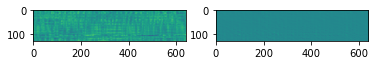

In [6]:
#%matplotlib tk
autoencoder = ConvolutionalAutoencoder()
autoencoder.build((None, 128,640,1))
autoencoder.summary()

for _input, target in autoencoder_datasets['train'].take(np.random.randint(0,200)):
    out = autoencoder(_input)
    plt.subplot(1,2,1)
    plt.imshow(_input[0][:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(out[0][:,:,0])

In [7]:
%matplotlib tk
# Initialize the loss-function
loss_func = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()
# Initialize Train-Object
trainer = train.Trainer(autoencoder, autoencoder_datasets, optimizer, loss_func)
# Initialize Plotting-Object
grapher = utilities.TrainingGrapher(2,1, supxlabel='Epochs', axs_xlabels=[['train loss', 'test loss']])

trainer.model_test()
for epoch in range(20):
    print(epoch, end='\r')  
    trainer.train_epoch()
    grapher.update([trainer.losses['train'], trainer.losses['test']])


2022-03-17 14:43:01.912692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-17 14:43:01.986914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [8]:
%matplotlib tk
#grapher.fig.set_size_inches(15, 8)
grapher.fig.savefig("apple.png")

In [9]:
for i, t in autoencoder_datasets['train'].take(8):
    out_enc = autoencoder.encoder(i)
    out_dec = autoencoder.decoder(out_enc)
    f, axs = plt.subplots(1,4,figsize=(15,15))
    axs[0].imshow(i[0][:,:,0])
    axs[1].imshow(t[0][:,:,0])
    axs[2].imshow(out_dec[0][:,:,0])
    # normalize each channel
    norm_enc = out_enc[0] / np.max(out_enc[0], (0, 1))[np.newaxis, np.newaxis, :]
    axs[3].imshow(norm_enc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [10]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
autoencoder.save(f'./models/saved_models/{title}')

2022-03-17 14:43:42.019918: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/saved_models/subject_one_no_augmentation_bs3/assets
